<a href="https://colab.research.google.com/github/gselivirov/NASA_forest/blob/main/NASA_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA - Nearest Earth Objects 
## knn, svc, and decision tree ensembles classifiers for cumulative data for Nearest Earth Objects by NASA
https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects



In [1]:
from sklearn import ensemble
from sklearn import model_selection as mls
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.svm import LinearSVC

import statsmodels.api as sm
from statsmodels.stats import outliers_influence 

from scipy import stats

import numpy as np
import pandas as pd
# from pandas_profiling import ProfileReport

from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
from zipfile import ZipFile
zip_file = ZipFile('archive.zip')
df = pd.read_csv(zip_file.open('neo_v2.csv'))

In [4]:
df = df.drop(["name", "orbiting_body", "sentry_object", "id"],axis=1)
# df.set_index("id", inplace=True)
df["hazardous"] = [int(obs) for obs in df["hazardous"]]
df["est_diameter"] = (df["est_diameter_min"]+df["est_diameter_max"])/2
df = df.drop(["est_diameter_min", "est_diameter_max"],axis=1)
df.head()

,relative_velocity,miss_distance,absolute_magnitude,hazardous,est_diameter
0,13569.249224,5.483974e+07,16.73,0,1.938843
1,73588.726663,6.143813e+07,20.00,1,0.430073
2,114258.692129,4.979872e+07,17.83,0,1.168268
3,24764.303138,2.543497e+07,22.20,0,0.156150
4,42737.733765,4.627557e+07,20.09,1,0.412613


## Exploratory analysis

In [ ]:
df.isnull().sum()

relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
est_diameter          0
dtype: int64

In [ ]:
df.hazardous.value_counts()

0    81996
1     8840
Name: hazardous, dtype: int64

In [ ]:
df.describe()

,relative_velocity,miss_distance,absolute_magnitude,hazardous,est_diameter
count,90836.000000,9.083600e+04,90836.000000,90836.000000,90836.000000
mean,48066.918918,3.706655e+07,23.527103,0.097318,0.206189
std,25293.296961,2.235204e+07,2.894086,0.296392,0.483001
min,203.346433,6.745533e+03,9.230000,0.000000,0.000985
25%,28619.020645,1.721082e+07,21.340000,0.000000,0.031156
50%,44190.117890,3.784658e+07,23.700000,0.000000,0.078260
75%,62923.604633,5.654900e+07,25.700000,0.000000,0.232029
max,236990.128088,7.479865e+07,33.200000,1.000000,61.311595


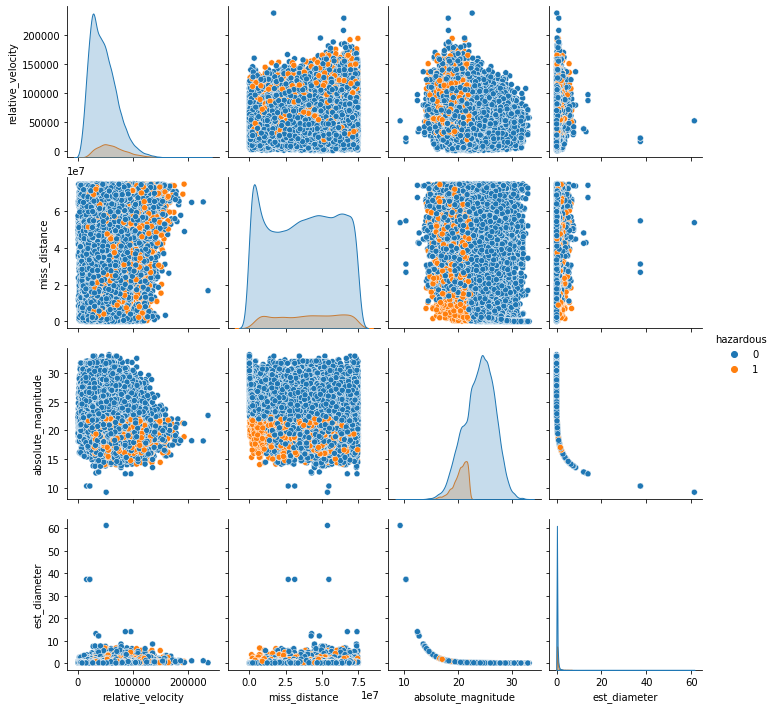

In [ ]:
sns.pairplot(df, hue= "hazardous")

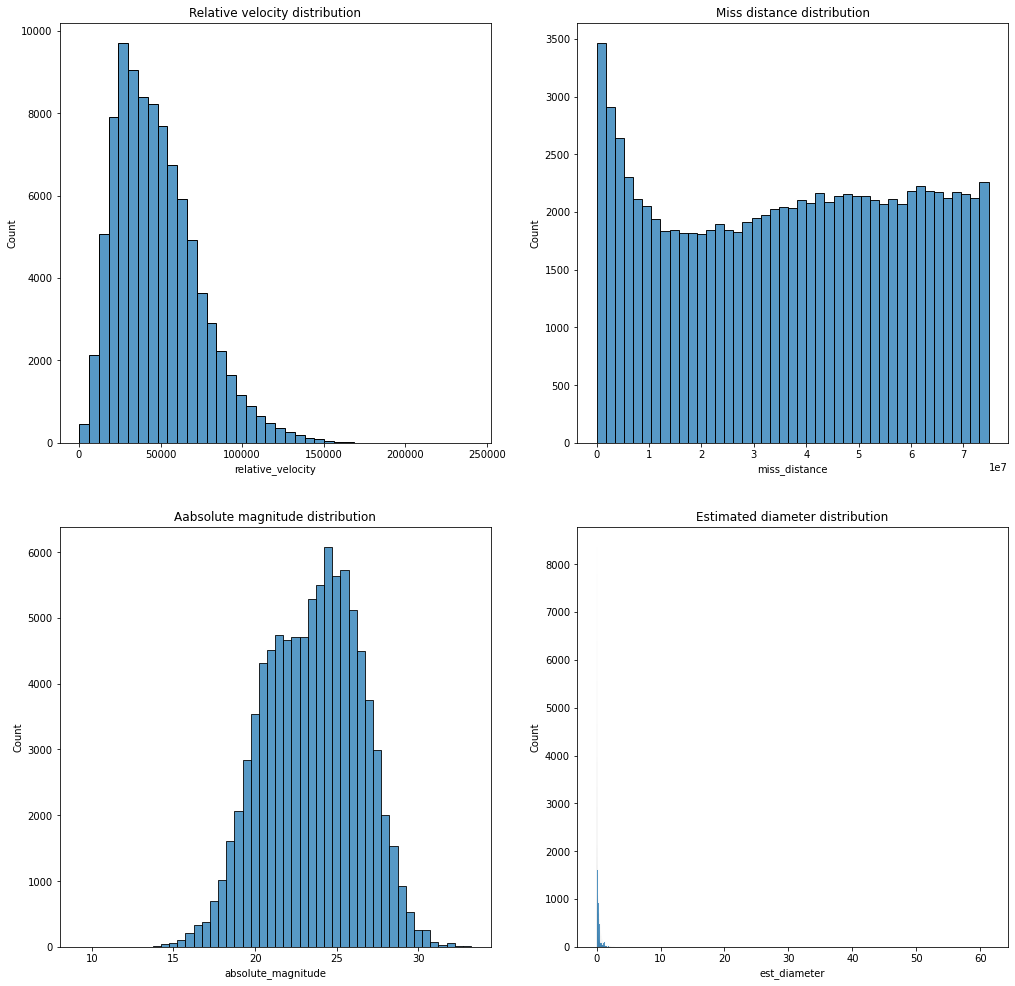

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (17,17))
sns.histplot(df["relative_velocity"], ax = ax[0][0], binwidth=6000)
ax[0][0].set_title("Relative velocity distribution")

sns.histplot(df["miss_distance"], ax = ax[0][1])
ax[0][1].set_title("Miss distance distribution")

sns.histplot(df["absolute_magnitude"], ax = ax[1][0], binwidth=0.5)
ax[1][0].set_title("Aabsolute magnitude distribution")

sns.histplot(df["est_diameter"], ax = ax[1][1])
ax[1][1].set_title("Estimated diameter distribution")


plt.show()

In [5]:
X = df.drop(["hazardous"], axis=1)
y = df.hazardous

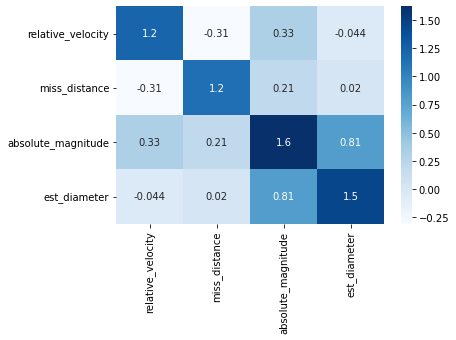

In [ ]:
ivcorr = np.linalg.inv(X.corr())
ivcorr = pd.DataFrame(ivcorr, index=X.columns, columns= X.columns)
sns.heatmap(ivcorr, cmap= "Blues", annot=True)

In [6]:
X_train, X_test, y_train, y_test = mls.train_test_split(X, y, test_size= 0.25, random_state= 5)

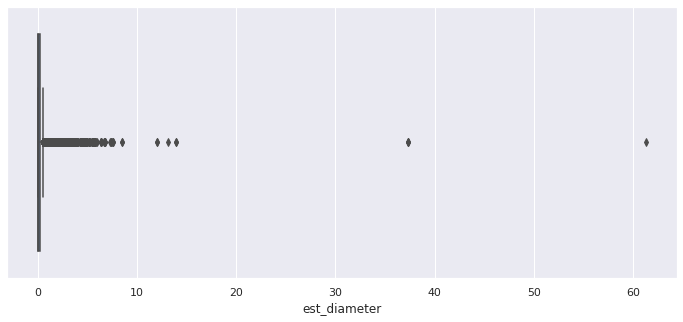

In [ ]:
fig, ax = plt.subplots(figsize = (12,5))
sns.boxplot(ax= ax, x = df["est_diameter"])
plt.show()

In [ ]:
def find_outliers_IQR(col):
  q1=col.quantile(0.25)
  q3=col.quantile(0.75)
  IQR = q3-q1
  outliers = col[((col<(q1-1.5*IQR)) | (col>(q3+1.5*IQR)))]
  return outliers

In [ ]:
df[df.index.isin(find_outliers_IQR(df.est_diameter).index)].hazardous.value_counts()

0    6177
1    2129
Name: hazardous, dtype: int64

## ~25% of hazardous objects are outliers

## Linear support vector classifier

In [7]:
min_on_training = X_train.min(axis=0)
range_on_training = (X_train - min_on_training).max(axis=0)
X_train_scaled = (X_train - min_on_training) / range_on_training
X_test_scaled = (X_test - min_on_training) / range_on_training

In [52]:
lsvc = LinearSVC()
lsvc_params = {"C": np.arange(0.01,1.1,0.01)}
lsvc_grid = mls.GridSearchCV(lsvc, lsvc_params, cv=10, scoring="f1")

In [53]:
lsvc_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09])},
             scoring='f1')

In [54]:
lsvc_grid.best_params_

{'C': 0.060000000000000005}

In [55]:
best_lsvc = lsvc_grid.best_estimator_
best_lsvc.score(X_test_scaled, y_test)
best_lsvc_pred = best_lsvc.predict(X_test_scaled)

In [56]:
lsvc_metrics = pd.DataFrame({"accuracy_score" : best_lsvc.score(X_test_scaled, y_test),
                            "f1_score" : metrics.f1_score(y_test,best_lsvc_pred),
                            "precision_score" : metrics.precision_score(y_test,best_lsvc_pred),
                            "recall_score" : metrics.recall_score(y_test,best_lsvc_pred)}, 
                           index=["lsvc"])
lsvc_metrics

,accuracy_score,f1_score,precision_score,recall_score
lsvc,0.901449,0.021853,0.490196,0.011176


## Kernelized SVC

In [32]:
from sklearn.svm import SVC
svc = SVC(C=4, gamma = 20)
svc.fit(X_train_scaled, y_train)
svc_pred = svc.predict(X_test_scaled)
svc.score(X_test_scaled, y_test), metrics.f1_score(y_test,svc_pred)

In [34]:
svc_metrics = pd.DataFrame({"accuracy_score" : svc.score(X_test_scaled, y_test),
                            "f1_score" : metrics.f1_score(y_test,svc_pred),
                            "precision_score" : metrics.precision_score(y_test,svc_pred),
                            "recall_score" : metrics.recall_score(y_test,svc_pred)}, 
                           index=["svc"])
svc_metrics

,accuracy_score,f1_score,precision_score,recall_score
svc,0.911357,0.227848,0.802703,0.132767


### Checking Logistic Regression assumptions

In [ ]:
df_out = df.copy()

X_out = df_out.drop("hazardous", axis=1)
y_out = df_out.hazardous
X_out_const = sm.add_constant(X_out)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
logit = sm.GLM(y_out, X_out_const, family=sm.families.Binomial())
logit_res = logit.fit()
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              hazardous   No. Observations:                90836
Model:                            GLM   Df Residuals:                    90831
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20285.
Date:                Tue, 26 Jul 2022   Deviance:                       40570.
Time:                        15:23:15   Pearson chi2:                 3.96e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 24.2809      0.372     65.256      0.000      23.552      25.010
relative_velocity   8.016e-06    4.7e-07     17.051      0.000    7.09e-06    8.94e-06
miss_distance      -2.057e-08   6.84e-10    -30.062      0.000   -2.19e-08   -1.92e-08
absolute_magnitude    -1.1573      0.016    -71.487      0.000      -1.189      -1.126
est_diameter          -3.2670      0.077    -42.531      0.000      -3.418      -3.116
======================================================================================
"""

In [ ]:
influence = logit_res.get_influence()
summary = influence.summary_frame()

diagnosis_df = summary.loc[:,['cooks_d']]

diagnosis_df['std_resid'] = stats.zscore(logit_res.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df

,cooks_d,std_resid
0,8.583056e-62,0.050641
1,1.133799e-51,0.237143
2,2.662777e-52,0.137512
3,3.426517e-54,0.055060
4,6.369092e-52,0.235024
...,...,...
90831,8.202362e-57,0.020778
90832,2.875557e-57,0.011266
90833,2.645000e-56,0.018996
90834,6.330858e-59,0.007676


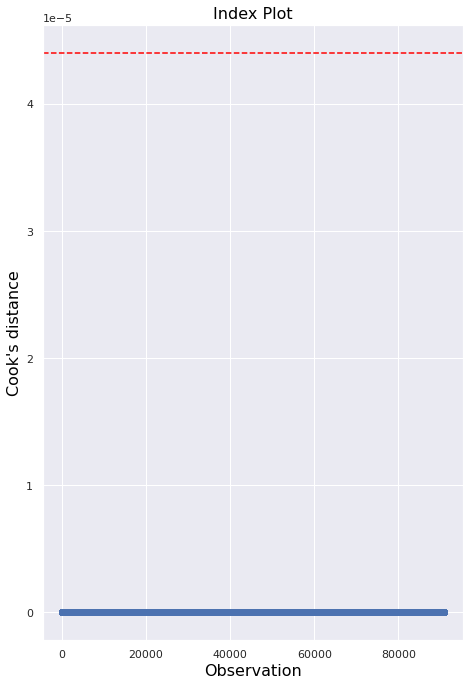

In [ ]:
cook_threshold = 4 / len(X_out)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y=cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

 None of the ouliers seem to be influential

#### Check multicollinearity
  * VIF < 5, no multicollinearity detected 

In [ ]:
x_temp = sm.add_constant(X)

vif = pd.DataFrame()
vif["VIF Factor"] = [outliers_influence.variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
# print(vif.round(1))
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,VIF Factor,features
0,135.414331,const
1,1.226724,relative_velocity
2,1.152634,miss_distance
3,1.622630,absolute_magnitude
4,1.458998,est_diameter


#### Perform Box-Tidwell transformation
  * all logits are statistically significant

In [ ]:
df_lt = df.copy()

df_lt["est_diameter_1"] = df["est_diameter"]+1

X_lt = df_lt.drop("hazardous", axis=1)
y_lt = df_lt.hazardous
X_lt_const = sm.add_constant(X_lt)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
box_tidwell = {}
for var in X_lt:
  box_tidwell[var+":Log_"+var] = X_lt[var] * np.log(X_lt[var])
  box_tidwell[var] = X_lt[var]


box_tidwell = pd.DataFrame(box_tidwell)
box_tidwell = box_tidwell.drop(["est_diameter_1", "est_diameter:Log_est_diameter"],axis=1)
box_tidwell_f = sm.add_constant(box_tidwell)
box_tidwell

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,relative_velocity:Log_relative_velocity,relative_velocity,miss_distance:Log_miss_distance,miss_distance,absolute_magnitude:Log_absolute_magnitude,absolute_magnitude,est_diameter,est_diameter_1:Log_est_diameter_1
0,1.291190e+05,13569.249224,9.772402e+08,5.483974e+07,47.131815,16.73,1.938843,3.168119
1,8.246535e+05,73588.726663,1.101803e+09,6.143813e+07,59.914645,20.00,0.430073,0.511574
2,1.330682e+06,114258.692129,8.826077e+08,4.979872e+07,51.366134,17.83,1.168268,1.678085
3,2.505444e+05,24764.303138,4.337079e+08,2.543497e+07,68.822049,22.20,0.156150,0.167752
4,4.557055e+05,42737.733765,8.167695e+08,4.627557e+07,60.274464,20.09,0.412613,0.487974
...,...,...,...,...,...,...,...,...
90831,5.656035e+05,52078.886692,2.008056e+08,1.230039e+07,80.471896,25.00,0.043007,0.043919
90832,4.952194e+05,46114.605073,9.674838e+08,5.432121e+07,84.710510,26.00,0.027136,0.027501
90833,6.758314e+04,7566.807732,4.874119e+08,2.840077e+07,78.787562,24.60,0.051706,0.053021
90834,7.712069e+05,69199.154484,1.239558e+09,6.869206e+07,92.436001,27.80,0.011845,0.011915


In [ ]:
box_tidwell_modell = sm.GLM(y_lt, box_tidwell_f, family=sm.families.Binomial()).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)


In [ ]:
box_tidwell_modell.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encount

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              hazardous   No. Observations:                90836
Model:                            GLM   Df Residuals:                    90828
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 26 Jul 2022   Deviance:                          nan
Time:                        15:27:25   Pearson chi2:                 3.99e+19
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      -1.81e+17   5.45e+07  -3.32e+09      0.000   -1.81e+17   -1.81e+17
relative_velocity:Log_relative_velocity   -9.602e+08     26.814  -3.58e+07      0.000    -9.6e+08    -9.6e+08
relative_velocity                          2.012e+10    318.601   6.31e+07      0.000    2.01e+10    2.01e+10
miss_distance:Log_miss_distance            1.201e+07      0.030   4.03e+08      0.000     1.2e+07     1.2e+07
miss_distance                             -2.305e+08      0.545  -4.23e+08      0.000   -2.31e+08   -2.31e+08
absolute_magnitude:Log_absolute_magnitude -8.051e+15   2.17e+06  -3.72e+09      0.000   -8.05e+15   -8.05e+15
absolute_magnitude                         3.308e+16   9.15e+06   3.61e+09      0.000    3.31e+16    3.31e+16
est_diameter                               5.427e+15   3.45e+06   1.57e+09      0.000    5.43e+15    5.43e+15
est_diameter_1:Log_est_diameter_1         -1.468e+15   8.84e+05  -1.66e+09      0.000   -1.47e+15   -1.47e+15
=============================================================================================================
"""

In [ ]:
X_lt_plot = df.drop("hazardous", axis=1)
y_lt_plot = df.hazardous


logit_results = sm.GLM(y_lt_plot, X_lt_plot, family=sm.families.Binomial()).fit()
predicted = logit_results.predict(X_lt_plot)


log_odds = np.log(predicted / (1 - predicted))

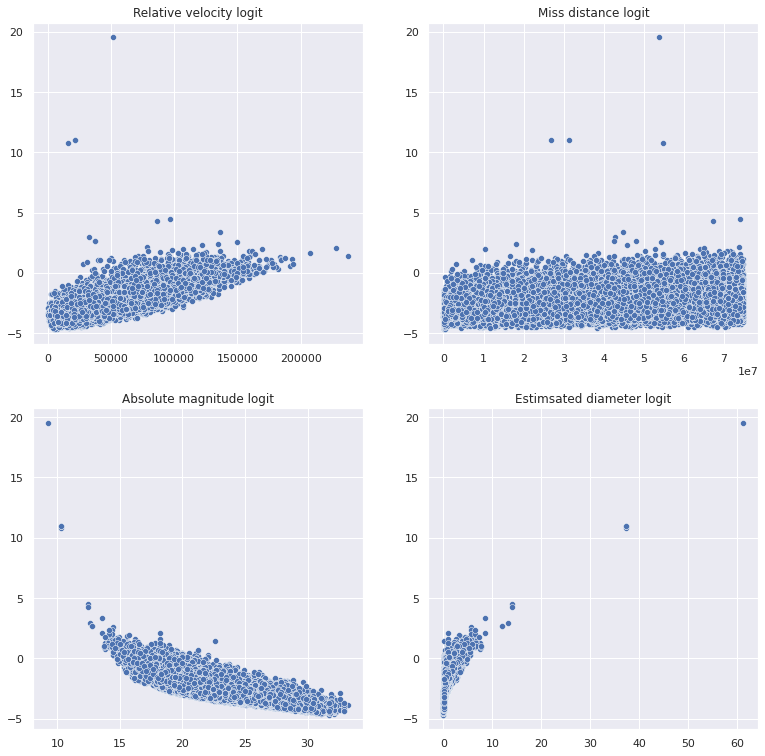

In [ ]:
fig, ax = plt.subplots(2,2,figsize =(13,13))

sns.scatterplot(ax = ax[0][0], x = X_out['relative_velocity'].values, y = log_odds)
ax[0][0].set_title("Relative velocity logit")

sns.scatterplot(ax = ax[0][1], x = X_out['miss_distance'].values, y = log_odds);
ax[0][1].set_title("Miss distance logit")

sns.scatterplot(ax = ax[1][0], x = X_out['absolute_magnitude'].values, y = log_odds);
ax[1][0].set_title("Absolute magnitude logit")

sns.scatterplot(ax = ax[1][1], x = X_out['est_diameter'].values, y = log_odds);
ax[1][1].set_title("Estimsated diameter logit")

plt.show()

### Overall, logistic regression seems to be non applicable

### K Nearest Neighbours as a benchmark test

In [36]:
knn = KNeighborsClassifier()
neighbor_params = {"n_neighbors": range(1,200,10)}
knn_grid = mls.GridSearchCV(knn, neighbor_params, cv=10, scoring="f1")

In [37]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 200, 10)}, scoring='f1')

In [38]:
best_knn = knn_grid.best_estimator_
knn_grid.best_params_

{'n_neighbors': 1}

In [39]:
knn_pred = best_knn.predict(X_test)
pd.Series(knn_pred).value_counts()

0    20513
1     2196
dtype: int64

In [40]:
knn_metrics = pd.DataFrame({"accuracy_score" : metrics.accuracy_score(y_test, knn_pred),
                            "f1_score" : metrics.f1_score(y_test,knn_pred),
                            "precision_score" : metrics.precision_score(y_test, knn_pred),
                            "recall_score" : metrics.recall_score(y_test, knn_pred)}, 
                           index=["knn"])

knn_metrics

,accuracy_score,f1_score,precision_score,recall_score
knn,0.839139,0.175953,0.177596,0.174341


## Random forest classifier 

In [42]:
clf_rf = ensemble.RandomForestClassifier(bootstrap= True, random_state= 5)
params = {"criterion": ["entropy"],
          "n_estimators": range(50,101,10),
          "max_depth": range(2,13,2),
          "min_samples_split": range(300, 1501, 300),
          "min_samples_leaf": range(150,751, 150)}

In [43]:
grid_clf = mls.RandomizedSearchCV(clf_rf, params, cv=5, scoring="f1")


In [44]:
grid_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
                   param_distributions={'criterion': ['entropy'],
                                        'max_depth': range(2, 13, 2),
                                        'min_samples_leaf': range(150, 751, 150),
                                        'min_samples_split': range(300, 1501, 300),
                                        'n_estimators': range(50, 101, 10)},
                   scoring='f1')

In [45]:
grid_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 750,
 'min_samples_split': 1500,
 'n_estimators': 50}

In [46]:
best_clf = grid_clf.best_estimator_
y_pred = best_clf.predict(X_test)
best_clf.score(X_test, y_test), metrics.f1_score(y_test,y_pred), metrics.precision_score(y_test, y_pred) ,metrics.recall_score(y_test, y_pred)

(0.9114007662160377,
 0.2570162481536189,
 0.7388535031847133,
 0.15556548949485918)

In [47]:
best_forest_metrics = pd.DataFrame({"accuracy_score" : best_clf.score(X_test, y_test),
                            "f1_score" : metrics.f1_score(y_test,y_pred),
                            "precision_score" : metrics.precision_score(y_test,y_pred),
                            "recall_score" : metrics.recall_score(y_test,y_pred)}, 
                           index=["best_forest"])
best_forest_metrics

,accuracy_score,f1_score,precision_score,recall_score
best_forest,0.911401,0.257016,0.738854,0.155565


In [50]:
importance_df = pd.DataFrame({"feature": list(X_train),
                              "importance_score": best_clf.feature_importances_})

importance_df.sort_values("importance_score", ascending=False)

,feature,importance_score
2,absolute_magnitude,0.569445
3,est_diameter,0.326068
1,miss_distance,0.065301
0,relative_velocity,0.039187


## Gradient Boosting machine

In [66]:
gbc = ensemble.GradientBoostingClassifier(random_state=5)
gbc_params = {"max_depth": range(1,6),
              "learning_rate": np.arange(0.1,1.1,0.2),
              "n_estimators": range(50,101,10)}
grid_gbc = mls.RandomizedSearchCV(gbc, gbc_params, cv=5, scoring="f1")

In [67]:
grid_gbc.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=5),
                   param_distributions={'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                                        'max_depth': range(1, 6),
                                        'n_estimators': range(50, 101, 10)},
                   scoring='f1')

In [73]:
best_gbc = grid_gbc.best_estimator_
gbc_pred = best_gbc.predict(X_test)

In [70]:
importance_df_gbc = pd.DataFrame({"feature": list(X_train),
                              "importance_score": best_gbc.feature_importances_})

importance_df_gbc.sort_values("importance_score", ascending=False)

,feature,importance_score
2,absolute_magnitude,0.531048
1,miss_distance,0.243297
3,est_diameter,0.130022
0,relative_velocity,0.095632


In [74]:
best_gbc_metrics = pd.DataFrame({"accuracy_score" : best_gbc.score(X_test, y_test),
                            "f1_score" : metrics.f1_score(y_test,gbc_pred),
                            "precision_score" : metrics.precision_score(y_test,gbc_pred),
                            "recall_score" : metrics.recall_score(y_test,gbc_pred)}, 
                           index=["best_gbc"])
best_gbc_metrics

,accuracy_score,f1_score,precision_score,recall_score
best_gbc,0.914968,0.433558,0.630546,0.330353


## Comparison of the results

In [75]:
best_forest_metrics.append([lsvc_metrics,svc_metrics,knn_metrics,best_gbc_metrics]).sort_values("f1_score", ascending = False)

,accuracy_score,f1_score,precision_score,recall_score
best_gbc,0.914968,0.433558,0.630546,0.330353
best_forest,0.911401,0.257016,0.738854,0.155565
svc,0.911357,0.227848,0.802703,0.132767
knn,0.839139,0.175953,0.177596,0.174341
lsvc,0.901449,0.021853,0.490196,0.011176
